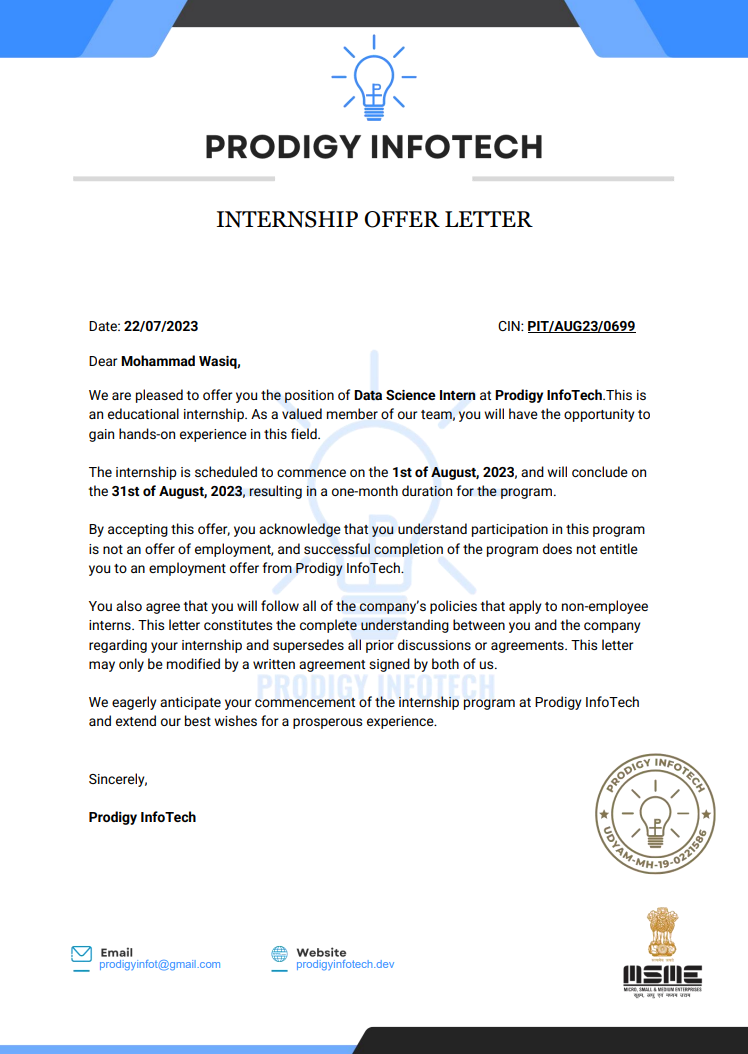

In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
print(os.listdir("../input"))

['historical-hourly-weather-data', 'stock-time-series-20050101-to-20171231']


# <a id='1'>1. Introduction to date and time</a>

## <a id='1.1'>1.1 Importing time series data</a>

### How to import data?
First, we import all the datasets needed for this kernel. The required time series column is imported as a datetime column using **parse_dates** parameter and is also selected as index of the dataframe using **index_col** parameter. 
#### Data being used:-
1. Google  Stocks Data
2. Humidity in different world cities
3. Microsoft  Stocks Data
3. Pressure in different world cities

In [2]:
google = pd.read_csv('../input/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv', 
                     index_col='Date', 
                     parse_dates=['Date'])
google.head()

Open    High     Low   Close    Volume   Name
Date                                                       
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL

In [3]:
humidity = pd.read_csv('../input/historical-hourly-weather-data/humidity.csv', 
                       index_col='datetime', 
                       parse_dates=['datetime'])
humidity.tail()

Vancouver  Portland    ...      Nahariyya  Jerusalem
datetime                                    ...                          
2017-11-29 20:00:00        NaN      81.0    ...            NaN        NaN
2017-11-29 21:00:00        NaN      71.0    ...            NaN        NaN
2017-11-29 22:00:00        NaN      71.0    ...            NaN        NaN
2017-11-29 23:00:00        NaN      71.0    ...            NaN        NaN
2017-11-30 00:00:00        NaN      76.0    ...            NaN        NaN

[5 rows x 36 columns]

## <a id='1.2'>1.2 Cleaning and preparing time series data</a>

### How to prepare data?
Google stocks data doesn't have any missing values but humidity data does have its fair share of missing values. It is cleaned using **fillna()** method with **ffill** parameter which propagates last valid observation to fill gaps

In [4]:
google.shape, humidity.shape

((3019, 6), (45253, 36))

In [5]:
google.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [6]:
humidity.isnull().sum()

Vancouver            1826
Portland              449
San Francisco         942
Seattle               289
Los Angeles           152
San Diego             344
Las Vegas             842
Phoenix              1308
Albuquerque           710
Denver               1808
San Antonio           564
Dallas                319
Houston               121
Kansas City           512
Minneapolis           510
Saint Louis          1289
Chicago              1109
Nashville             567
Indianapolis          695
Atlanta               422
Detroit               862
Jacksonville          209
Charlotte             589
Miami                1087
Pittsburgh            522
Toronto               728
Philadelphia          624
New York             1624
Montreal             1696
Boston                449
Beersheba             859
Tel Aviv District    1113
Eilat                 970
Haifa                 818
Nahariyya             817
Jerusalem             906
dtype: int64

In [7]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method='ffill')
humidity.head()

Vancouver  Portland    ...      Nahariyya  Jerusalem
datetime                                    ...                          
2012-10-01 13:00:00       76.0      81.0    ...           51.0       50.0
2012-10-01 14:00:00       76.0      80.0    ...           51.0       50.0
2012-10-01 15:00:00       76.0      80.0    ...           51.0       50.0
2012-10-01 16:00:00       77.0      80.0    ...           51.0       50.0
2012-10-01 17:00:00       78.0      79.0    ...           51.0       50.0

[5 rows x 36 columns]

## <a id='1.3'>1.3 Visualizing the datasets</a>

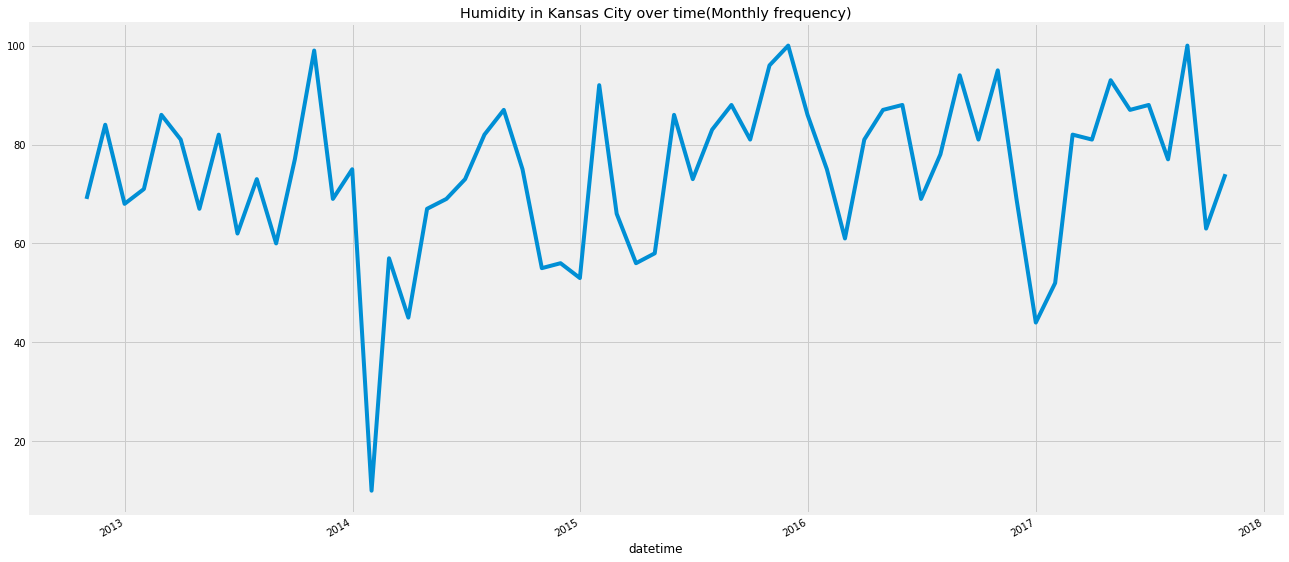

In [8]:
# asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
plt.figure(figsize=(20,10))
humidity["Kansas City"].asfreq('M').plot()
plt.title('Humidity in Kansas City over time(Monthly frequency)')
plt.show()

In [9]:
google.head()

Open    High     Low   Close    Volume   Name
Date                                                       
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL

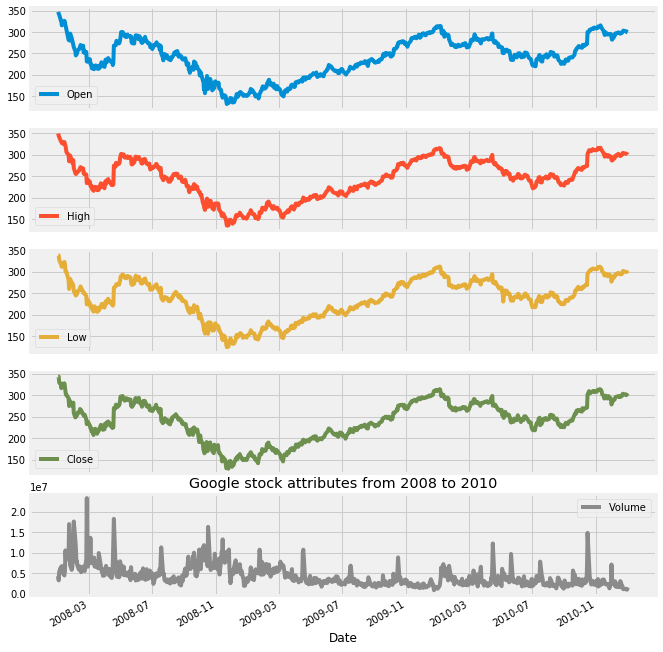

In [10]:
google['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

## <a id='1.4'>1.4 Timestamps and Periods</a>

### What are timestamps and periods and how are they useful?
Timestamps are used to represent a point in time. Periods represent an interval in time. Periods can used to check if a specific event in the given period. They can also be converted to each other's form.

In [11]:
# Creating a Timestamp
timestamp = pd.Timestamp(2017, 1, 1, 12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [12]:
# Creating a period
period = pd.Period('2017-01-01')
period

Period('2017-01-01', 'D')

In [13]:
# Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time

True

In [14]:
# can access year, month, date from Period, Timestamp
print(period.year, period.month, period.day)

print(timestamp.year, timestamp.month, timestamp.day)

2017 1 1
2017 1 1


In [15]:
# Converting timestamp to period
new_period = timestamp.to_period(freq='H')
new_period

Period('2017-01-01 12:00', 'H')

In [16]:
# Converting period to timestamp
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp

Timestamp('2017-01-01 00:00:00')

## <a id='1.5'>1.5 Using date_range</a>

### What is date_range and how is it useful?
**date_range** is a method that returns  a fixed frequency datetimeindex. It is quite useful when creating your own time series attribute for pre-existing data or arranging the whole data around the time series attribute created by you.

In [17]:
# Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [18]:
len(dr1)

9

In [19]:
# Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [20]:
# Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [21]:
# Creating a datetimeindex specifying start date , end date and periods
dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

## <a id='1.6'>1.6 Using to_datetime</a> 

pandas.to_datetime() is used for converting arguments to datetime. Here, a DataFrame is converted to a datetime series.

In [22]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
df

year  month  day
0  2015      2    4
1  2016      3    5

In [23]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [24]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

## <a id='1.7'>1.7 Shifting and lags</a>

We can shift index by desired number of periods with an optional time frequency. This is useful when comparing the time series with a past of itself

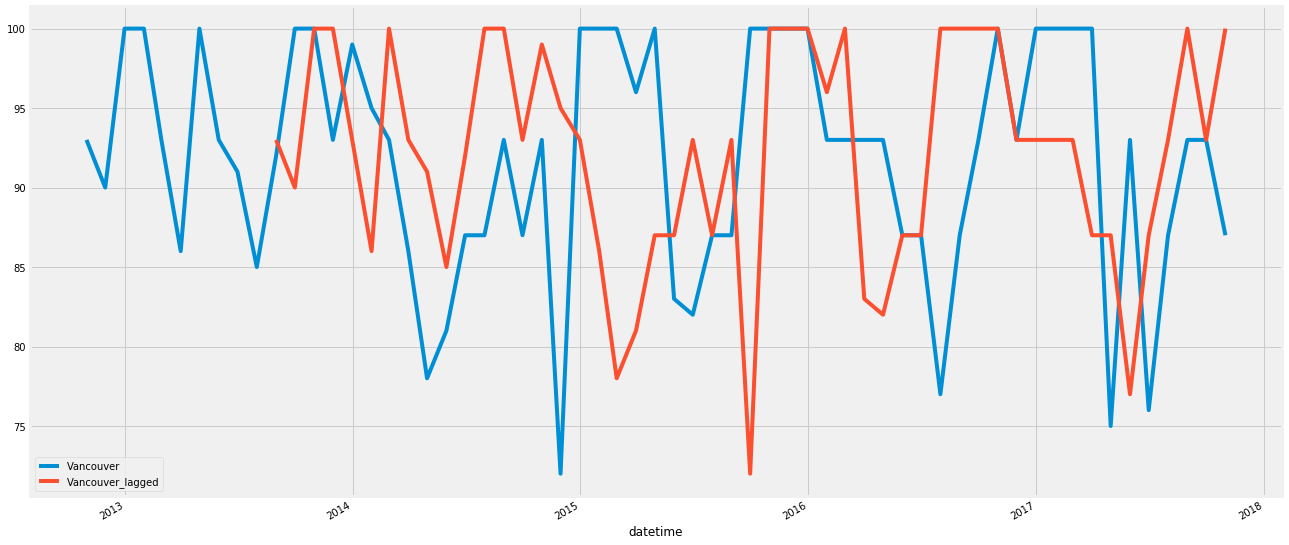

In [25]:
plt.figure(figsize=(20,10))
humidity["Vancouver"].asfreq('M').plot(legend=True)
shifted = humidity["Vancouver"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Vancouver','Vancouver_lagged'])
plt.show()

## <a id='#1.8'>1.8 Resampling</a>
**Upsampling** - Time series is resampled from low frequency to high frequency(Monthly to daily frequency). It involves filling or interpolating missing data

**Downsampling** - Time series is resampled from high frequency to low frequency(Weekly to monthly frequency). It involves aggregation of existing data.


In [26]:
# Let's use pressure data to demonstrate this
pressure = pd.read_csv('../input/historical-hourly-weather-data/pressure.csv', 
                       index_col='datetime', 
                       parse_dates=['datetime'])
pressure.tail()

Vancouver  Portland    ...      Nahariyya  Jerusalem
datetime                                    ...                          
2017-11-29 20:00:00        NaN    1031.0    ...            NaN        NaN
2017-11-29 21:00:00        NaN    1030.0    ...            NaN        NaN
2017-11-29 22:00:00        NaN    1030.0    ...            NaN        NaN
2017-11-29 23:00:00        NaN    1029.0    ...            NaN        NaN
2017-11-30 00:00:00        NaN    1029.0    ...            NaN        NaN

[5 rows x 36 columns]

Sigh! A lot of cleaning is required.

In [27]:
pressure.shape

(45253, 36)

In [28]:
pressure.isnull().sum()

Vancouver            4234
Portland                4
San Francisco         815
Seattle                13
Los Angeles           252
San Diego             175
Las Vegas              88
Phoenix               594
Albuquerque           456
Denver                543
San Antonio            17
Dallas                 60
Houston                 9
Kansas City           121
Minneapolis            17
Saint Louis            68
Chicago               725
Nashville             147
Indianapolis          289
Atlanta                49
Detroit                 5
Jacksonville           15
Charlotte               3
Miami                 794
Pittsburgh             46
Toronto               175
Philadelphia            4
New York             1041
Montreal              994
Boston                  7
Beersheba             806
Tel Aviv District     930
Eilat                 792
Haifa                 798
Nahariyya             795
Jerusalem             799
dtype: int64

In [29]:
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method='ffill')
pressure.tail()

Vancouver  Portland    ...      Nahariyya  Jerusalem
datetime                                    ...                          
2017-11-29 20:00:00     1021.0    1031.0    ...         1023.0     1011.0
2017-11-29 21:00:00     1021.0    1030.0    ...         1023.0     1011.0
2017-11-29 22:00:00     1021.0    1030.0    ...         1023.0     1011.0
2017-11-29 23:00:00     1021.0    1029.0    ...         1023.0     1011.0
2017-11-30 00:00:00     1021.0    1029.0    ...         1023.0     1011.0

[5 rows x 36 columns]

In [30]:
pressure = pressure.fillna(method='bfill')
pressure.head()

Vancouver  Portland    ...      Nahariyya  Jerusalem
datetime                                    ...                          
2012-10-01 13:00:00      807.0    1024.0    ...         1013.0      990.0
2012-10-01 14:00:00      807.0    1024.0    ...         1013.0      990.0
2012-10-01 15:00:00      807.0    1024.0    ...         1013.0      990.0
2012-10-01 16:00:00      807.0    1024.0    ...         1013.0      990.0
2012-10-01 17:00:00      807.0    1024.0    ...         1013.0      990.0

[5 rows x 36 columns]

First, we used **ffill** parameter which propagates last valid observation to fill gaps. Then we use **bfill** to propogate next valid observation to fill gaps.

In [31]:
# Shape before resampling(downsampling)
pressure.shape

(45252, 36)

In [32]:
# We downsample from hourly to 3 day frequency aggregated using mean
pressure = pressure.resample('3D').mean()
pressure.head()

Vancouver     ...       Jerusalem
datetime                             ...                
2012-10-01 13:00:00   946.652778     ...      990.611111
2012-10-04 13:00:00  1018.875000     ...      989.902778
2012-10-07 13:00:00  1014.125000     ...      989.722222
2012-10-10 13:00:00  1011.375000     ...      988.013889
2012-10-13 13:00:00  1010.208333     ...      990.750000

[5 rows x 36 columns]

In [33]:
# Shape after resampling(downsampling)
pressure.shape

(629, 36)

Much less rows are left. Now, we will upsample from 3 day frequency to daily frequency

In [34]:
pressure = pressure.resample('D').pad()
pressure.head()

Vancouver     Portland     ...      Nahariyya   Jerusalem
datetime                                 ...                           
2012-10-01          NaN          NaN     ...            NaN         NaN
2012-10-02   946.652778  1022.597222     ...         1013.0  990.611111
2012-10-03   946.652778  1022.597222     ...         1013.0  990.611111
2012-10-04   946.652778  1022.597222     ...         1013.0  990.611111
2012-10-05  1018.875000  1022.819444     ...         1013.0  989.902778

[5 rows x 36 columns]

In [35]:
# Shape after resampling(upsampling)
pressure.shape

(1885, 36)

Again an increase in number of rows. Resampling is cool when used properly.

# <a id='2'>2. Finance and statistics</a>

In [36]:
google.head()

Open    High     Low   Close    Volume   Name
Date                                                       
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL

## <a id='2.1'>2.1 Percent change</a>

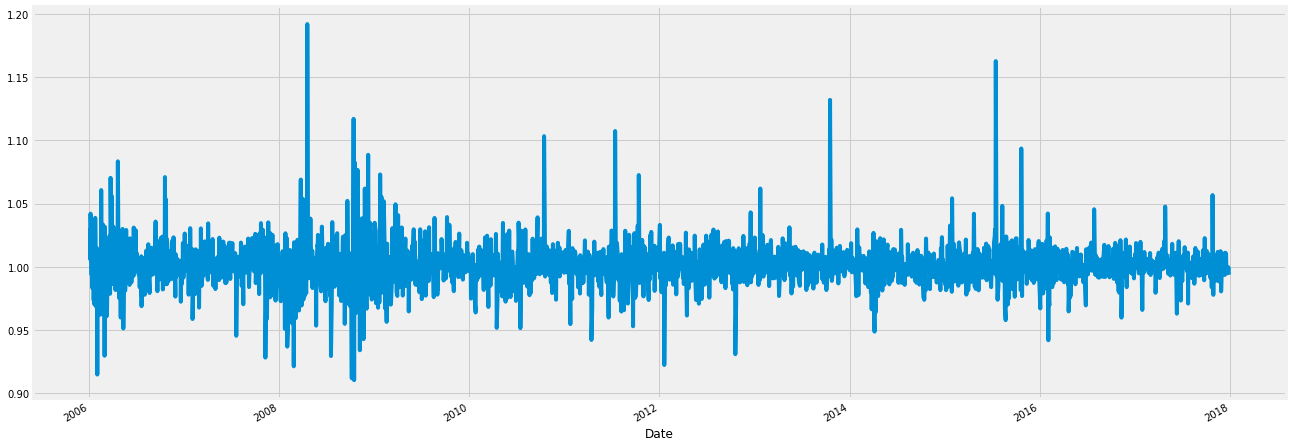

In [37]:
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))
plt.show()

## <a id='2.2'>2.2 Stock returns</a> 

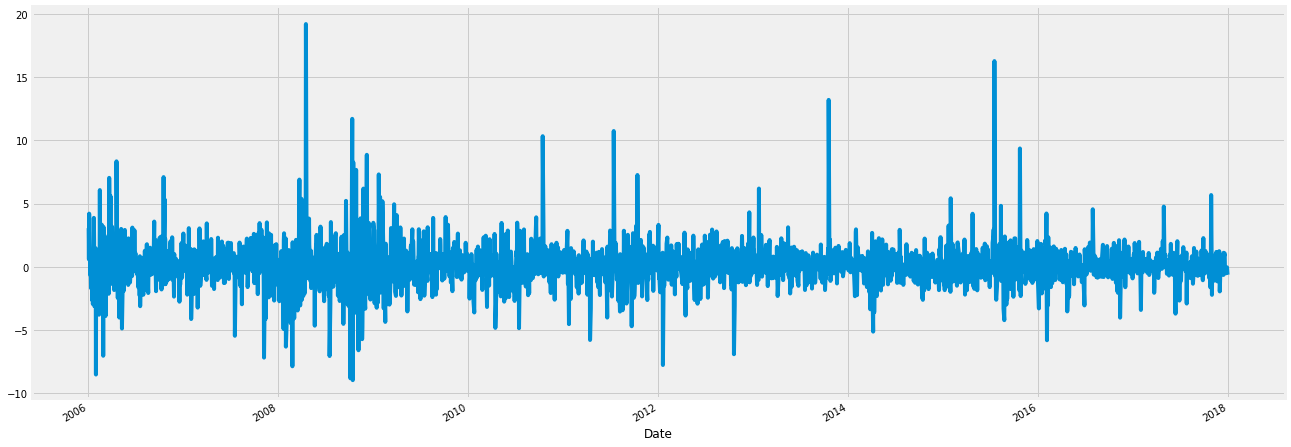

In [38]:
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))
plt.show()

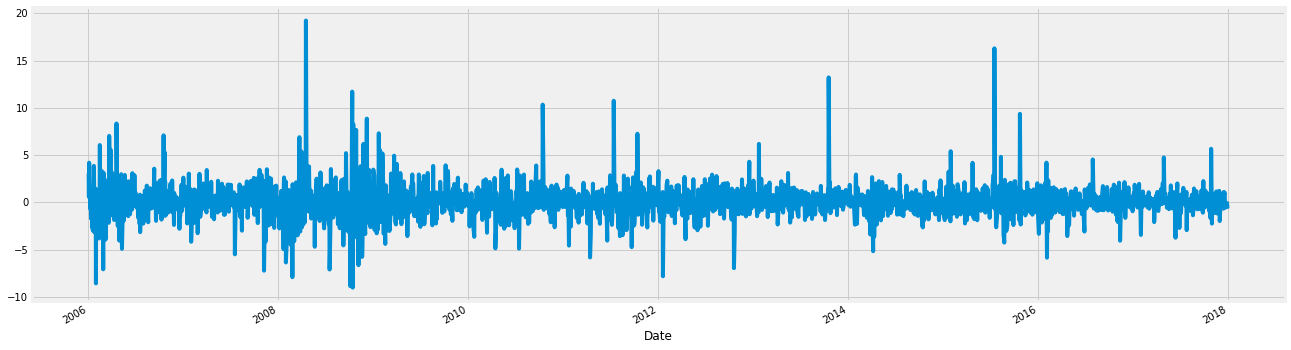

In [39]:
google.High.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns

## <a id='2.3'>2.3 Absolute change in successive rows</a>

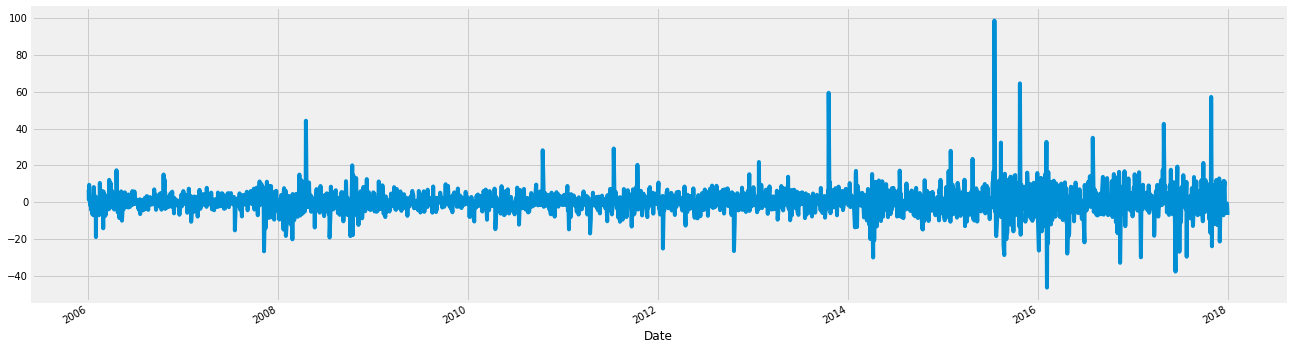

In [40]:
google.High.diff().plot(figsize=(20,6))

## <a id='2.4'>2.4 Comparing two or more time series</a> 

We will compare 2 time series by normalizing them. This is achieved by dividing each time series element of all time series by the first element. This way both series start at the same point and can be easily compared.

In [41]:
# We choose microsoft stocks to compare them with google
microsoft = pd.read_csv('../input/stock-time-series-20050101-to-20171231/MSFT_2006-01-01_to_2018-01-01.csv', 
                        index_col='Date', 
                        parse_dates=['Date'])
microsoft.head()

Open   High    Low  Close     Volume  Name
Date                                                   
2006-01-03  26.25  27.00  26.10  26.84   79974418  MSFT
2006-01-04  26.77  27.08  26.77  26.97   57975661  MSFT
2006-01-05  26.96  27.13  26.91  26.99   48247610  MSFT
2006-01-06  26.89  27.00  26.49  26.91  100969092  MSFT
2006-01-09  26.93  27.07  26.76  26.86   55627836  MSFT

In [42]:
microsoft.shape

(3019, 6)

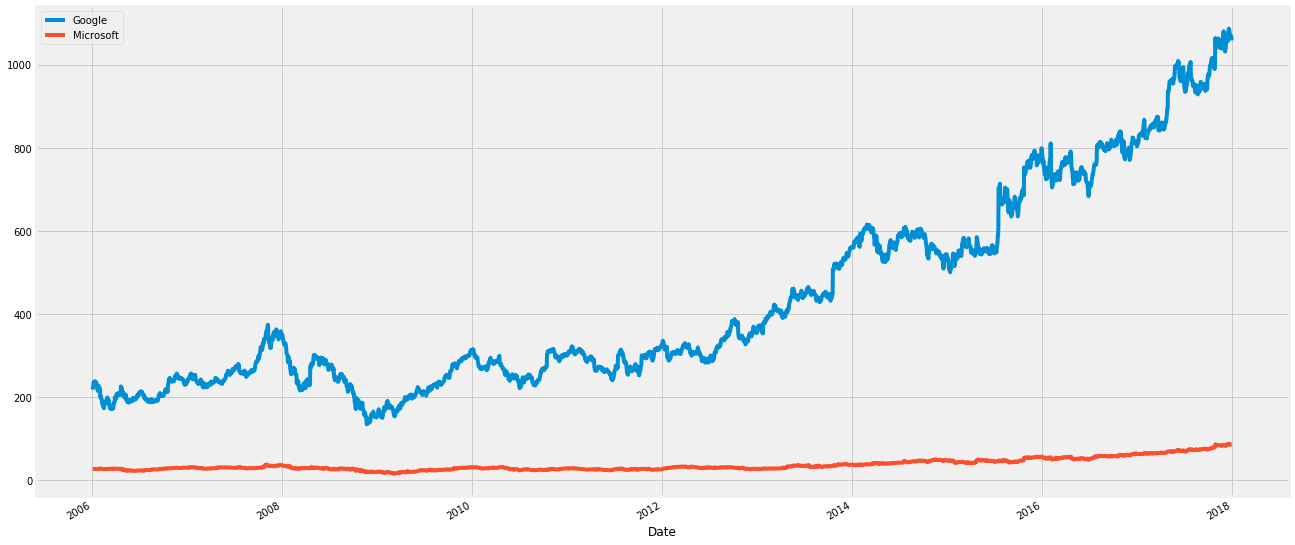

In [43]:
# Plotting before normalization
plt.figure(figsize=(20,10))
google.High.plot()
microsoft.High.plot()
plt.legend(['Google','Microsoft'])
plt.show()

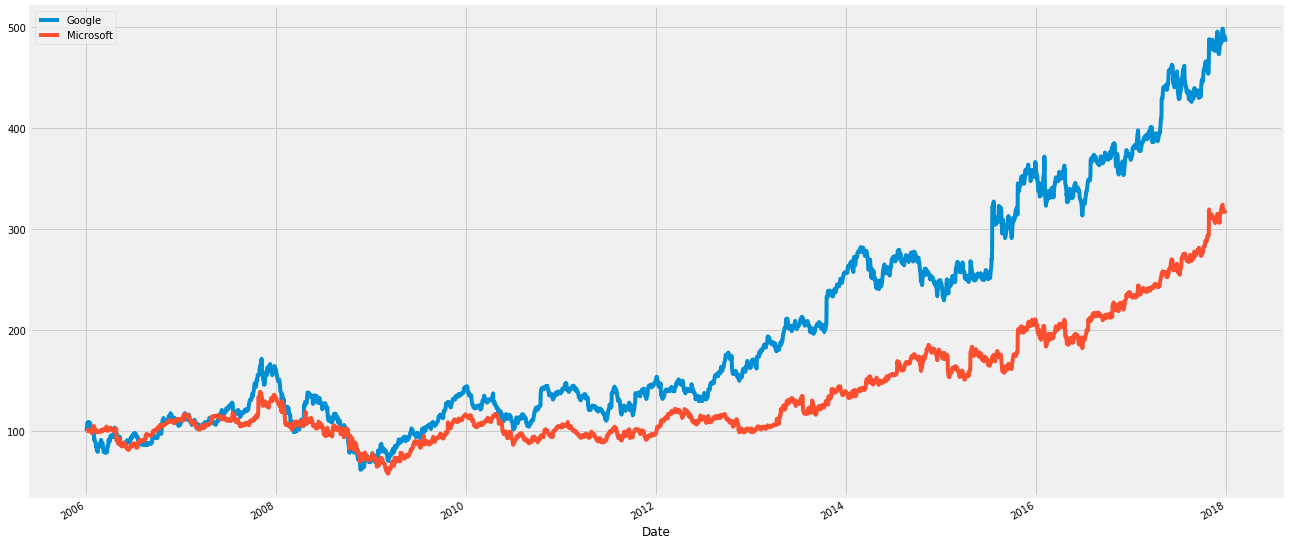

In [44]:
# Normalizing and comparison
# Both stocks start from 100
plt.figure(figsize=(20,10))
normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)
normalized_google.plot()
normalized_microsoft.plot()
plt.legend(['Google','Microsoft'])
plt.show()

You can clearly see how google outperforms microsoft over time.

## <a id='2.5'>2.5 Window functions</a>
Window functions are used to identify sub periods, calculates sub-metrics of sub-periods.

**Rolling** - Same size and sliding

**Expanding** - Contains all prior values

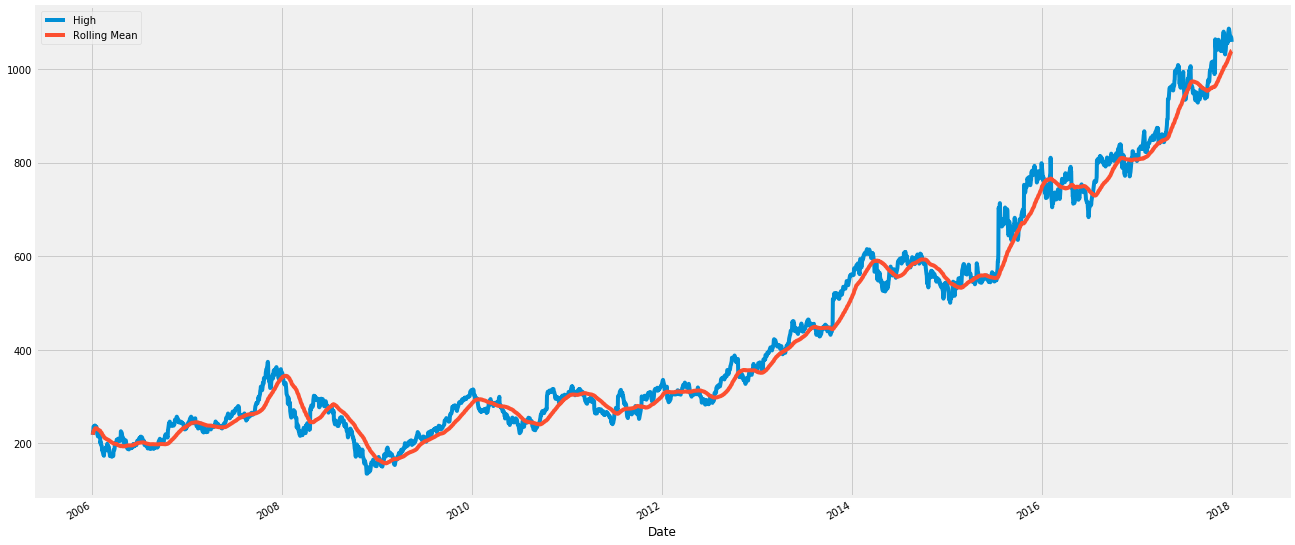

In [45]:
# Rolling window functions
plt.figure(figsize=(20,10))
rolling_google = google.High.rolling('90D').mean()
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.show()

Now, observe that rolling mean plot is a smoother version of the original plot.

In [46]:
microsoft["High_exp"] = microsoft.High.expanding().mean()

In [47]:
microsoft[["High", "High_exp"]].iloc[:10]

High   High_exp
Date                        
2006-01-03  27.00  27.000000
2006-01-04  27.08  27.040000
2006-01-05  27.13  27.070000
2006-01-06  27.00  27.052500
2006-01-09  27.07  27.056000
2006-01-10  27.02  27.050000
2006-01-11  27.39  27.098571
2006-01-12  27.26  27.118750
2006-01-13  27.25  27.133333
2006-01-17  27.19  27.139000

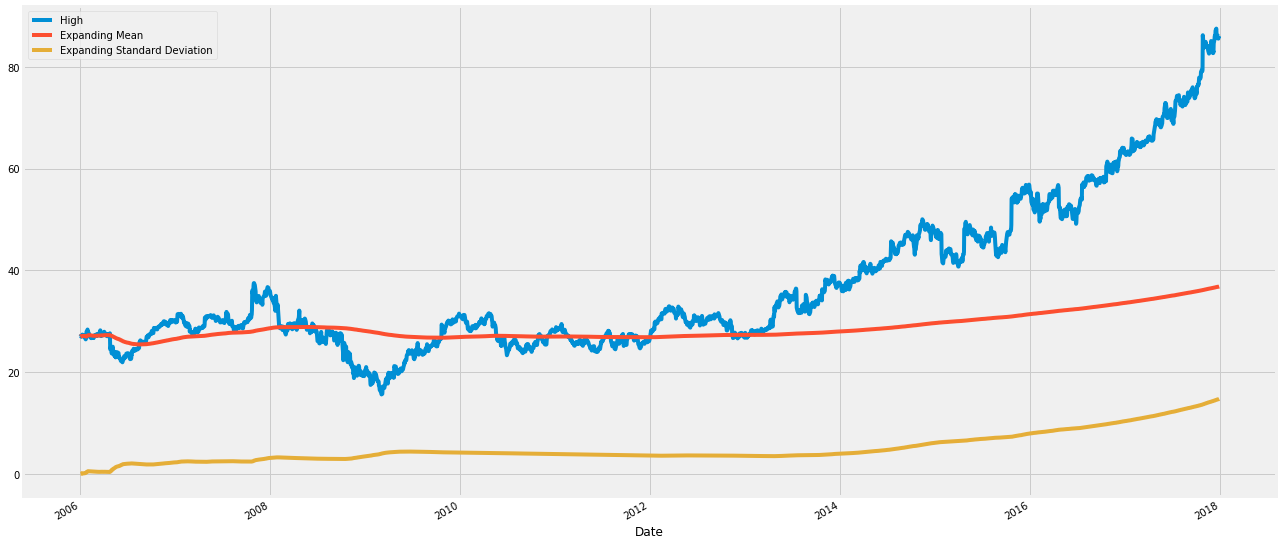

In [48]:
# Expanding window functions
plt.figure(figsize=(20,10))
microsoft_mean = microsoft.High.expanding().mean()
microsoft_std = microsoft.High.expanding().std()
microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

## <a id='2.6'>2.6 OHLC charts</a>
An OHLC chart is any type of price chart that shows the open, high, low and close price of a certain time period. Open-high-low-close Charts (or OHLC Charts) are used as a trading tool to visualise and analyse the price changes over time for securities, currencies, stocks, bonds, commodities, etc. OHLC Charts are useful for interpreting the day-to-day sentiment of the market and forecasting any future price changes through the patterns produced.

The y-axis on an OHLC Chart is used for the price scale, while the x-axis is the timescale. On each single time period, an OHLC Charts plots a symbol that represents two ranges: the highest and lowest prices traded, and also the opening and closing price on that single time period (for example in a day). On the range symbol, the high and low price ranges are represented by the length of the main vertical line. The open and close prices are represented by the vertical positioning of tick-marks that appear on the left (representing the open price) and on right (representing the close price) sides of the high-low vertical line.

Colour can be assigned to each OHLC Chart symbol, to distinguish whether the market is "bullish" (the closing price is higher then it opened) or "bearish" (the closing price is lower then it opened).

<img src="https://datavizcatalogue.com/methods/images/anatomy/SVG/OHLC_chart.svg">

Source: [Datavizcatalogue](https://datavizcatalogue.com/methods/OHLC_chart.html)

In [49]:
# OHLC chart of June 2008
trace = go.Ohlc(x=google['06-2008'].index,
                open=google['06-2008'].Open,
                high=google['06-2008'].High,
                low=google['06-2008'].Low,
                close=google['06-2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [50]:
# OHLC chart of 2008
trace = go.Ohlc(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [51]:
# OHLC chart of [2006-2018]
trace = go.Ohlc(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_ohlc')

 ## <a id='2.7'>2.7 Candlestick charts</a>
This type of chart is used as a trading tool to visualise and analyse the price movements over time for securities, derivatives, currencies, stocks, bonds, commodities, etc. Although the symbols used in Candlestick Charts resemble a Box Plot, they function differently and therefore, are not to be confused with one another.

Candlestick Charts display multiple bits of price information such as the open price, close price, highest price and lowest price through the use of candlestick-like symbols. Each symbol represents the compressed trading activity for a single time period (a minute, hour, day, month, etc). Each Candlestick symbol is plotted along a time scale on the x-axis, to show the trading activity over time.

The main rectangle in the symbol is known as the real body, which is used to display the range between the open and close price of that time period. While the lines extending from the bottom and top of the real body is known as the lower and upper shadows (or wick). Each shadow represents the highest or lowest price traded during the time period represented. When the market is Bullish (the closing price is higher than it opened), then the body is coloured typically white or green. But when the market is Bearish (the closing price is lower than it opened), then the body is usually coloured either black or red.

<img src="https://datavizcatalogue.com/methods/images/anatomy/SVG/candlestick_chart.svg">

Candlestick Charts are great for detecting and predicting market trends over time and are useful for interpreting the day-to-day sentiment of the market, through each candlestick symbol's colouring and shape. For example, the longer the body is, the more intense the selling or buying pressure is. While, a very short body, would indicate that there is very little price movement in that time period and represents consolidation.

Candlestick Charts help reveal the market psychology (the fear and greed experienced by sellers and buyers) through the various indicators, such as shape and colour, but also by the many identifiable patterns that can be found in Candlestick Charts. In total, there are 42 recognised patterns that are divided into simple and complex patterns. These patterns found in Candlestick Charts are useful for displaying price relationships and can be used for predicting the possible future movement of the market. You can find a list and description of each pattern here.

Please bear in mind, that Candlestick Charts don't express the events taking place between the open and close price - only the relationship between the two prices. So you can't tell how volatile trading was within that single time period.

Source: [Datavizcatalogue](https://datavizcatalogue.com/methods/candlestick_chart.html)

In [52]:
# Candlestick chart of march 2008
trace = go.Candlestick(x=google['03-2008'].index,
                open=google['03-2008'].Open,
                high=google['03-2008'].High,
                low=google['03-2008'].Low,
                close=google['03-2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

In [53]:
# Candlestick chart of 2008
trace = go.Candlestick(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

In [54]:
# Candlestick chart of 2006-2018
trace = go.Candlestick(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_candlestick')

## <a id='2.8'>2.8 Autocorrelation and Partial Autocorrelation</a>
* Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
* Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags.  The terms can be interpreted the same way as a standard  linear regression, that is the contribution of a change in that particular lag while holding others constant. 

Source: [Quora](https://www.quora.com/What-is-the-difference-among-auto-correlation-partial-auto-correlation-and-inverse-auto-correlation-while-modelling-an-ARIMA-series)

## Autocorrelation

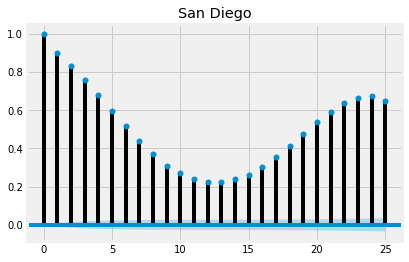

In [55]:
# Autocorrelation of humidity of San Diego
plot_acf(humidity["San Diego"],
         lags=25,
         title="San Diego")
plt.show()

 As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.

## Partial Autocorrelation

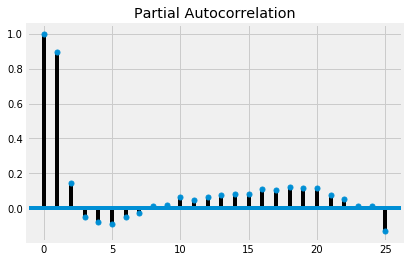

In [56]:
# Partial Autocorrelation of humidity of San Diego
plot_pacf(humidity["San Diego"],lags=25)
plt.show()

Though it is statistically signficant, partial autocorrelation after first 2 lags is very low.

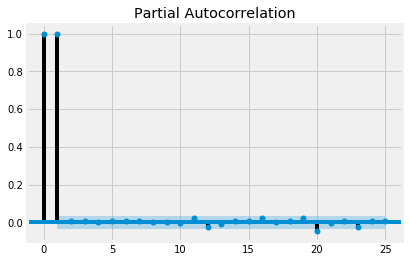

In [57]:
# Partial Autocorrelation of closing price of microsoft stocks
plot_pacf(microsoft["Close"],lags=25)
plt.show()

Here, only 0th, 1st and 20th lag are statistically significant.

# <a id='3'>3. Time series decomposition and Random walks</a>

## <a id='3.1'>3.1. Trends, seasonality and noise</a>
These are the components of a time series
* Trend - Consistent upwards or downwards slope of a time series
* Seasonality - Clear periodic pattern of a time series(like sine funtion)
* Noise - Outliers or missing values

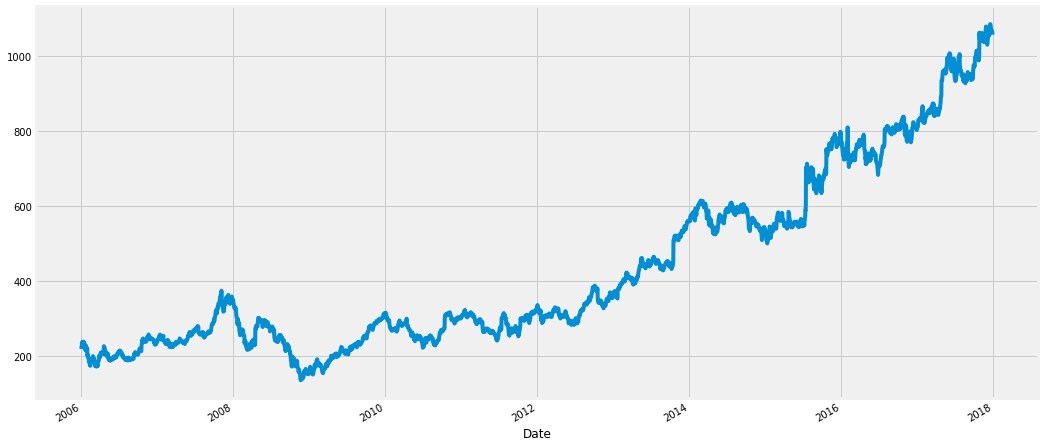

In [58]:
# Let's take Google stocks High for this
google["High"].plot(figsize=(16,8))

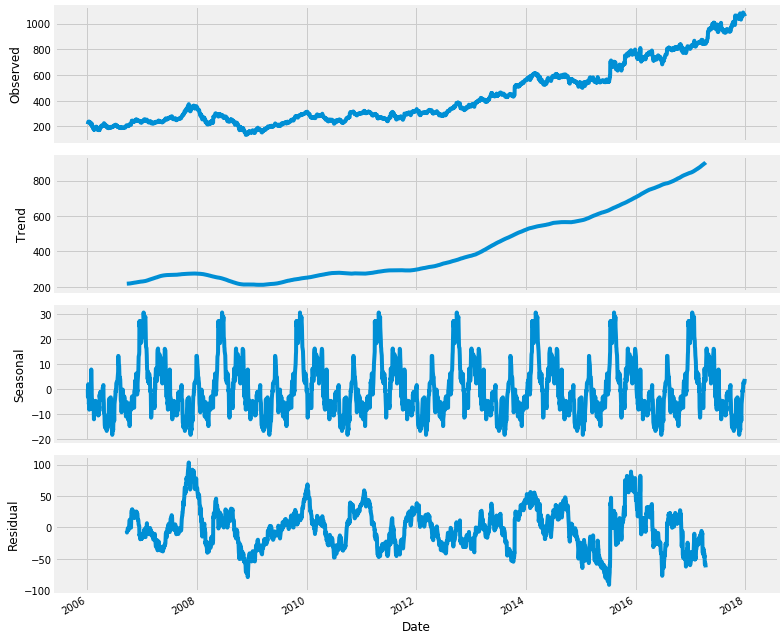

In [59]:
# Now, for decomposition...
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"],freq=360) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()

* There is clearly an upward trend in the above plot.
* You can also see the uniform seasonal change.
* Non-uniform noise that represent outliers and missing values

## <a id='3.2'>3.2. White noise</a>
White noise has...
* Constant mean
* Constant variance
* Zero auto-correlation at all lags

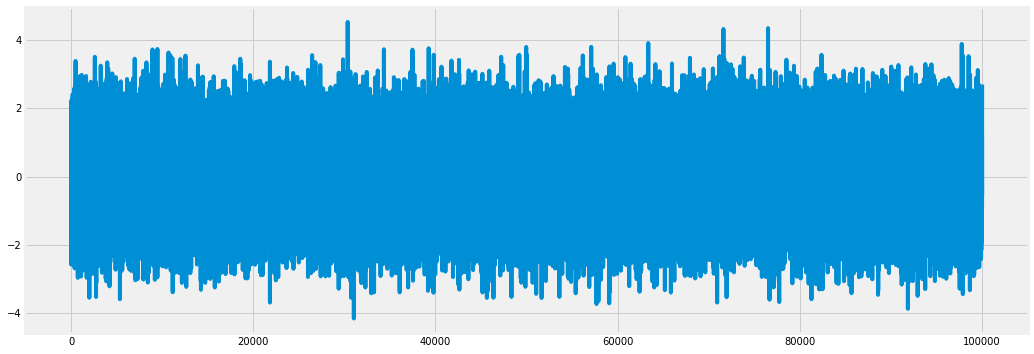

In [60]:
# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=100000)
# loc is mean, scale is variance
plt.plot(white_noise)

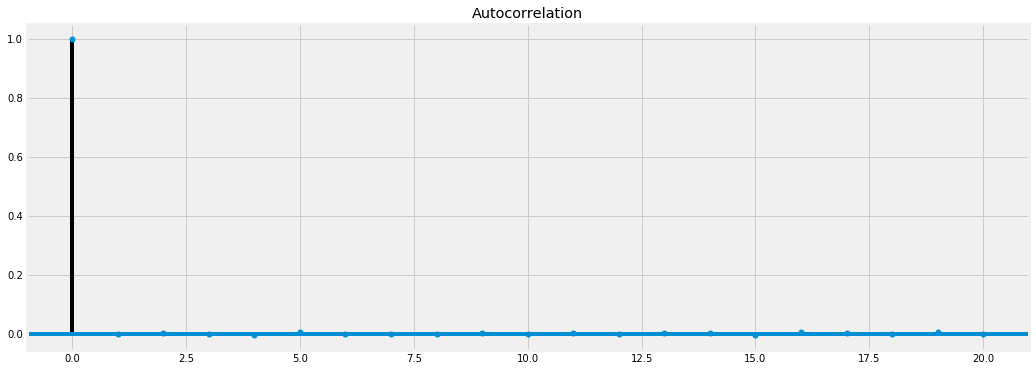

In [61]:
# Plotting autocorrelation of white noise
plot_acf(white_noise,lags=20)
plt.show()

See how all lags are statistically insigficant as they lie inside the confidence interval(shaded portion).

## <a id='3.3'>3.3. Random Walk</a>
A random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers. 

In general if we talk about stocks, Today's Price = Yesterday's Price + Noise

#### P<sub>t</sub> = P<sub>t-1</sub> + ε<sub>t</sub> 

Random walks can't be forecasted because well, noise is random.

Random Walk with Drift(drift(μ) is zero-mean)
#### P<sub>t</sub> - P<sub>t-1</sub> = μ + ε<sub>t</sub> 
<br>
Regression test for random walk <br>
#### P<sub>t</sub> = α + βP<sub>t-1</sub> + ε<sub>t</sub>
#### Equivalent to  P<sub>t</sub> - P<sub>t-1</sub> = α + βP<sub>t-1</sub> + ε<sub>t</sub>
<br>
Test:
#### H<sub>0</sub>: β = 1 (This is a random walk)
#### H<sub>1</sub>: β < 1 (This is not a random walk)
<br>
Dickey-Fuller Test:
#### H<sub>0</sub>: β = 0 (This is a random walk)
#### H<sub>1</sub>: β < 0 (This is not a random walk)

### Augmented Dickey-Fuller test
An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. It is basically Dickey-Fuller test with more lagged changes on RHS.

In [62]:
# Augmented Dickey-Fuller test on volume of google and microsoft stocks 
adf = adfuller(microsoft["Volume"])
print("p-value of microsoft: {}".format(float(adf[1])))
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))

p-value of microsoft: 0.00032015252776519936
p-value of google: 6.510719605768194e-07


##### As microsoft has p-value 0.0003201525 which is less than 0.05, null hypothesis is rejected and this is not a random walk.
##### Now google has p-value 0.0000006510 which is more than 0.05, null hypothesis is rejected and this is not a  random walk.

### Generating a random walk

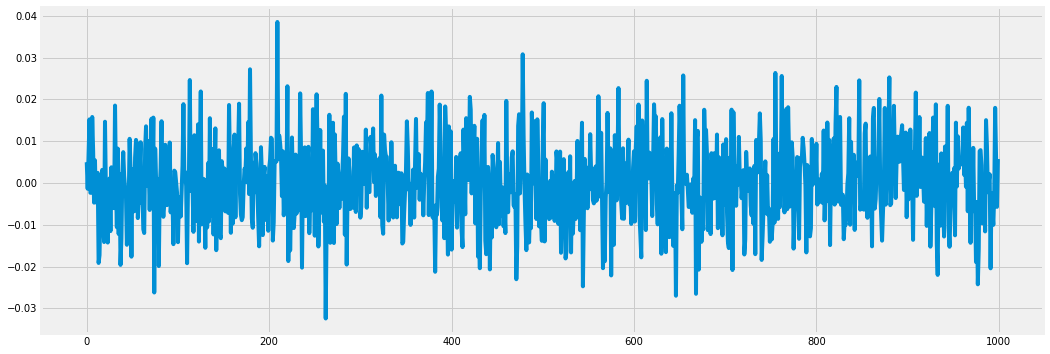

In [63]:
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

In [64]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
iplot(fig, filename='Basic Distplot')

## <a id='3.4'>3.4 Stationarity</a>
A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.
* Strong stationarity:  is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.
* Weak stationarity: is a process where mean, variance, autocorrelation are constant throughout the time

Stationarity is important as  non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff() method can easily convert a non-stationary series to a stationary series.

We will try to decompose seasonal component of the above decomposed time series.

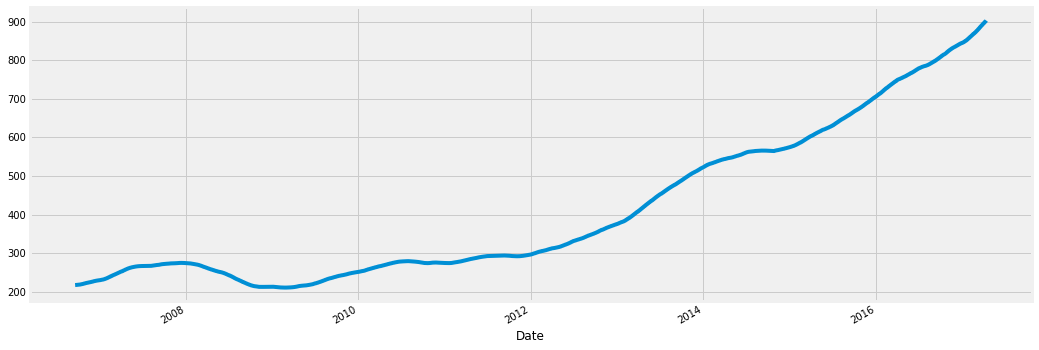

In [65]:
# The original non-stationary plot
decomposed_google_volume.trend.plot()

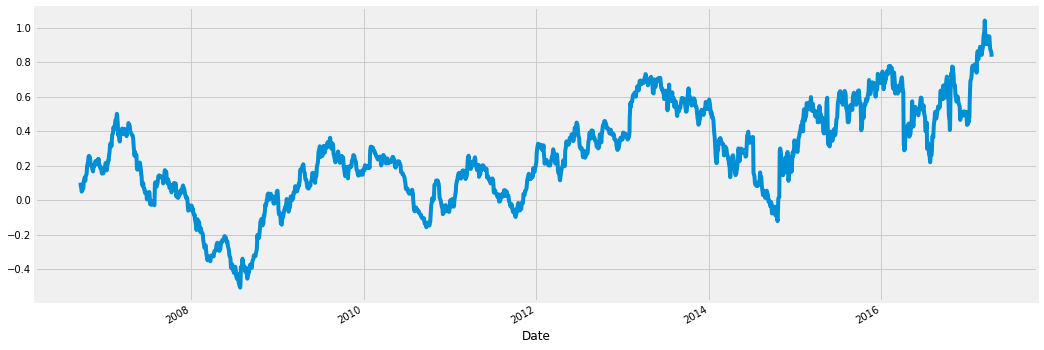

In [66]:
# The new stationary plot
decomposed_google_volume.trend.diff().plot()

# <a id='4'>4. Modelling using statstools</a>

#### What are `Endogenous` and `Exogenous` variables?

In time series analysis, endogenous and exogenous variables are two types of variables that are used to model and analyze the behavior of a time series.

1. `Endogenous Variables`: Endogenous variables are those variables that are directly influenced by the system being studied or the time series itself. They are also known as dependent variables or response variables. In the context of time series analysis, endogenous variables represent the variable of interest that we want to model or forecast. These variables are typically observed over time and are affected by their own past values and potentially other variables in the system.

    **For example, if we are analyzing the sales data of a product over time, the sales figures would be the endogenous variable. The current sales value would depend on the past sales values and potentially other factors such as marketing efforts or pricing strategies.**

2. `Exogenous Variables`: Exogenous variables, on the other hand, are variables that are external to the system being studied or the time series itself. They are also known as independent variables or explanatory variables. Exogenous variables are not directly influenced by the time series but may have an impact on the behavior of the endogenous variable.

    **Continuing with the sales example, exogenous variables could include factors like advertising expenditure, competitor's prices, or economic indicators like GDP. These variables are not determined by the sales themselves but are included in the analysis to account for their influence on the sales pattern.**

    In time series modeling, exogenous variables can be used to improve the accuracy of forecasting or to provide additional insights into the relationship between the endogenous variable and the external factors affecting it. They can be included in the model using techniques like regression or dynamic regression models.

    It's worth noting that the distinction between endogenous and exogenous variables is context-dependent. A variable can be considered endogenous in one analysis while being treated as exogenous in another analysis, depending on the specific research question and the available data.

## <a id='4.1'>4.1 AR models</a>
 An autoregressive (AR) model is a representation of a type of random process; as such, it is used to describe certain time-varying processes in nature, economics, etc. The autoregressive model specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term); thus the model is in the form of a stochastic difference equation.
 #### AR(1) model
 R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ε<sub>t</sub>
 ##### As RHS has only one lagged value(R<sub>t-1</sub>)this is called AR model of order 1 where μ is mean and ε is noise at time t
 If ϕ = 1, it is random walk. Else if ϕ = 0, it is white noise. Else if -1 < ϕ < 1, it is stationary. If ϕ is -ve, there is men reversion. If ϕ is +ve, there is momentum.
 #### AR(2) model
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ε<sub>t</sub>
 #### AR(3) model
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ϕ<sub>3</sub>R<sub>t-3</sub> + ε<sub>t</sub>

## Simulating AR(1) model

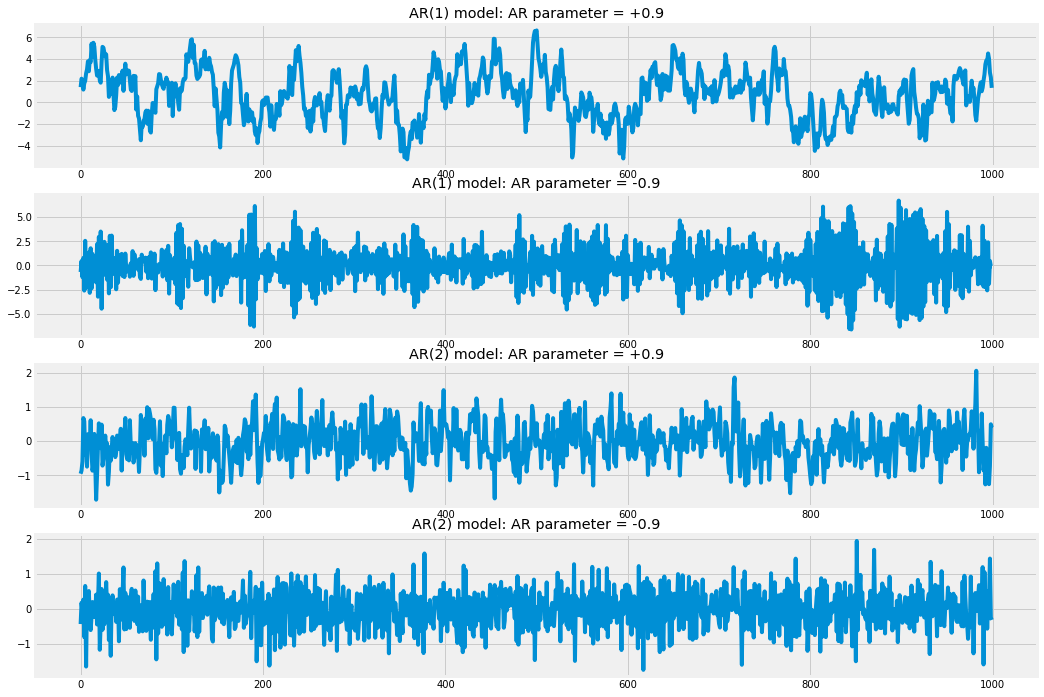

In [67]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)

# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9

plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)

# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

## Forecasting a simulated model

In [68]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Wed, 05 Jul 2023   AIC                           2837.403
Time:                        18:54:05   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots           

ϕ is around 0.9 which is what we chose as AR parameter in our first simulated model.

## Predicting the models

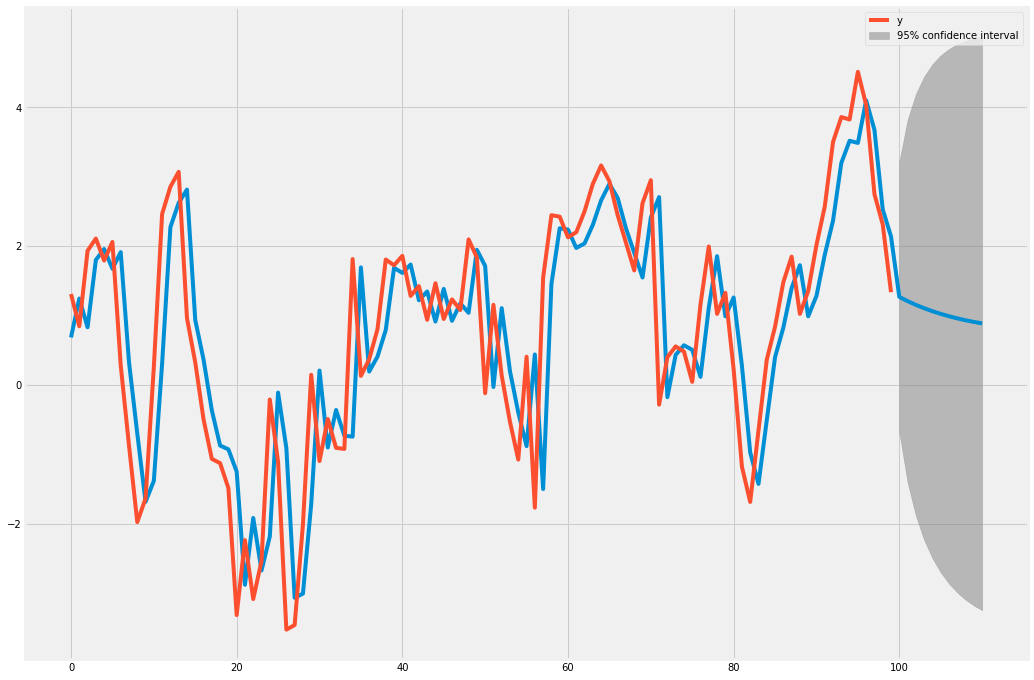

In [69]:
# Predicting simulated AR(1) model 
result.plot_predict(start=900, end=1010)
plt.show()

In [70]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054544358292.


y is predicted plot. Quite neat!

## Fitting an ARMA model to humidity data

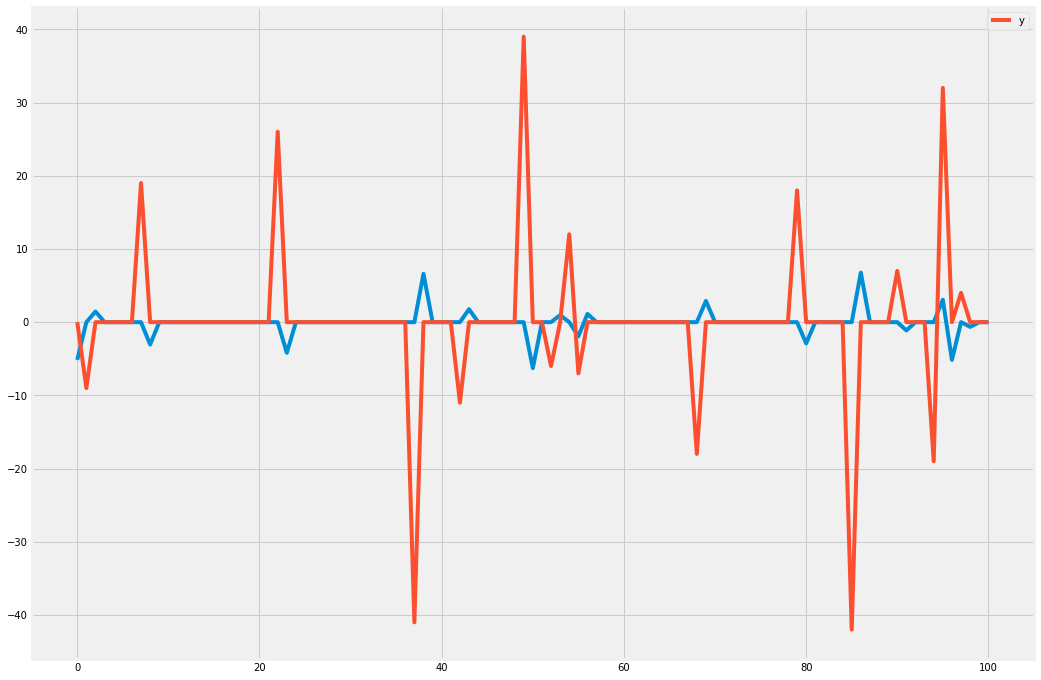

In [71]:
# Predicting humidity level of Montreal
humid = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=1000, end=1100)
plt.show()

In [72]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7.218388589479766.


 Not quite impressive. But let's try google stocks. 

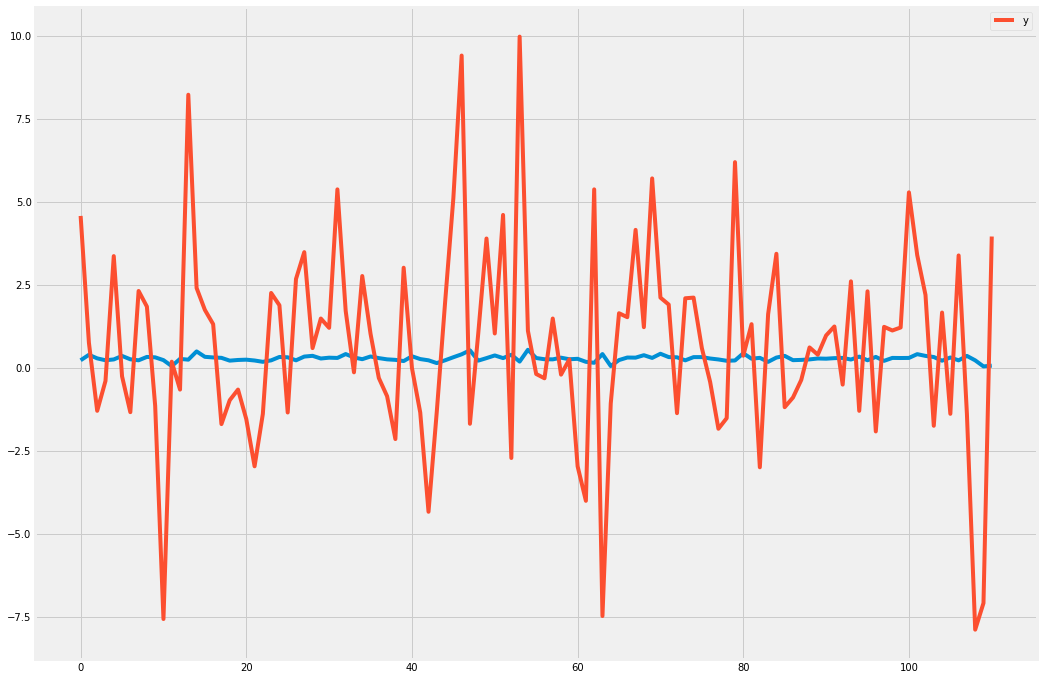

In [73]:
# Predicting closing prices of google
humid = ARMA(google["Close"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=900, end=1010)
plt.show()

There are always better models.

## <a id='4.2'>4.2 MA models</a>
The moving-average (MA) model is a common approach for modeling univariate time series. The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.
#### MA(1) model
R<sub>t</sub> = μ  +  ϵ<sub>t</sub>1 + θϵ<sub>t-1</sub>

It translates to Today's returns = mean + today's noise + yesterday's noise
##### As there is only 1 lagged value in RHS, it is an MA model of order 1

## Simulating MA(1) model

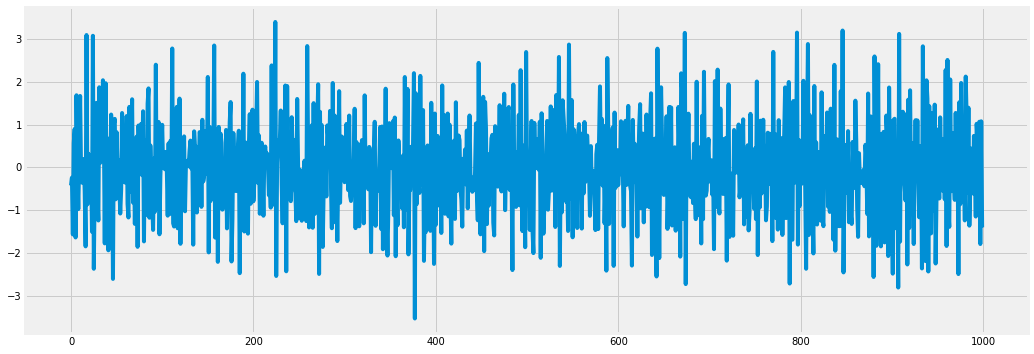

In [74]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
plt.plot(sim1)

## Forecasting the simulated MA model

In [75]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1423.276
Method:                       css-mle   S.D. of innovations              1.004
Date:                Wed, 05 Jul 2023   AIC                           2852.553
Time:                        18:54:08   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.014     -1.652      0.099      -0.050       0.004
ma.L1.y       -0.5650      0.027    -20.797      0.000      -0.618      -0.512
                                    Roots           

## Prediction using MA models

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                45251
Model:                     ARMA(0, 3)   Log Likelihood             -153516.982
Method:                       css-mle   S.D. of innovations              7.197
Date:                Wed, 05 Jul 2023   AIC                         307043.965
Time:                        18:54:09   BIC                         307087.564
Sample:                             0   HQIC                        307057.686
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.031     -0.025      0.980      -0.061       0.060
ma.L1.y       -0.1621      0.005    -34.507      0.000      -0.171      -0.153
ma.L2.y        0.0386      0.005      8.316      0.0

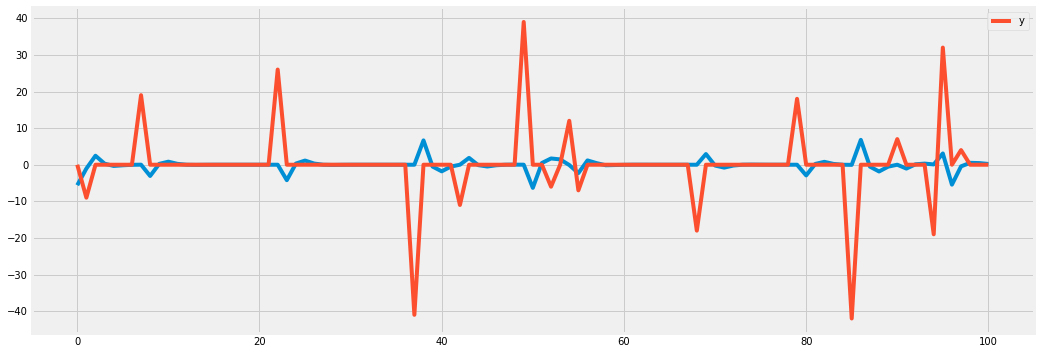

In [76]:
# Forecasting and predicting montreal humidity
model = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [77]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 11.345129665763626.


Now, for ARMA models.

## <a id='4.3'>4.3 ARMA models</a>
Autoregressive–moving-average (ARMA) models provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression and the second for the moving average. It's the fusion of AR and MA models.
### ARMA(1,1) model
### R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ϵ<sub>t</sub> + θϵ<sub>t-1</sub> 
Basically, Today's return = mean + Yesterday's return + noise + yesterday's noise.

## Prediction using ARMA models
I am not simulating any model because it's quite similar to AR and MA models. Just  forecasting and predictions for this one.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 3)   Log Likelihood              -55408.974
Method:                       css-mle   S.D. of innovations       22751607.377
Date:                Wed, 05 Jul 2023   AIC                         110833.948
Time:                        18:54:13   BIC                         110882.047
Sample:                             0   HQIC                        110851.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.03e+04   9913.993     -2.047      0.041   -3.97e+04    -866.151
ar.L1.y        0.2052      0.159      1.287      0.198      -0.107       0.518
ar.L2.y        0.7297      0.179      4.082      0.0

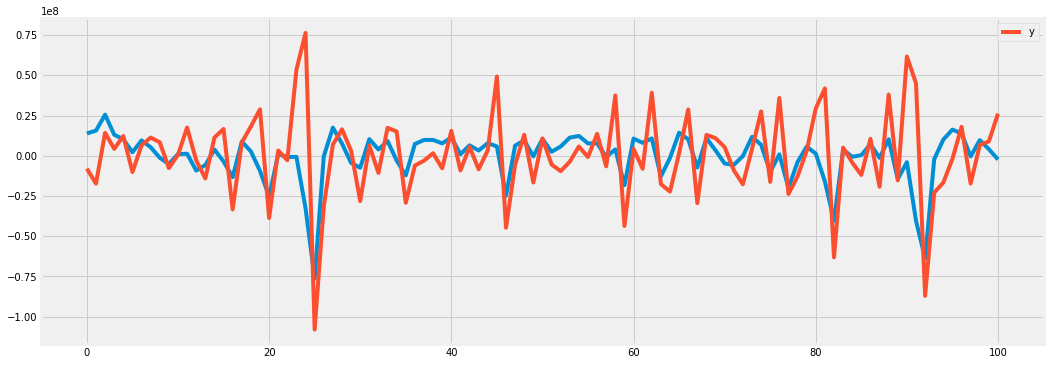

In [78]:
# Forecasting and predicting microsoft stocks volume
model = ARMA(microsoft["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [79]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 38038336.51508923.


ARMA model shows much better results than AR and MA models.

## <a id='4.4'>4.4 ARIMA models</a>
An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.
ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter
### ARIMA(1,0,0)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub>**
### ARIMA(1,0,1)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>**
### ARIMA(1,1,1)
**Δy<sub>t</sub> = a<sub>1</sub>Δy<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>** where **Δy<sub>t</sub> = y<sub>t</sub> - y<sub>t-1</sub>**

## Prediction using ARIMA model

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -56385.467
Method:                       css-mle   S.D. of innovations       31647215.014
Date:                Wed, 05 Jul 2023   AIC                         112778.933
Time:                        18:54:16   BIC                         112802.981
Sample:                             1   HQIC                        112787.581
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9984.0302   2.48e+05      0.040      0.968   -4.75e+05    4.95e+05
ar.L1.D.y     -0.8716      0.016    -53.758      0.000      -0.903      -0.840
ar.L2.D.y     -0.4551      0.016    -28.071      0.0

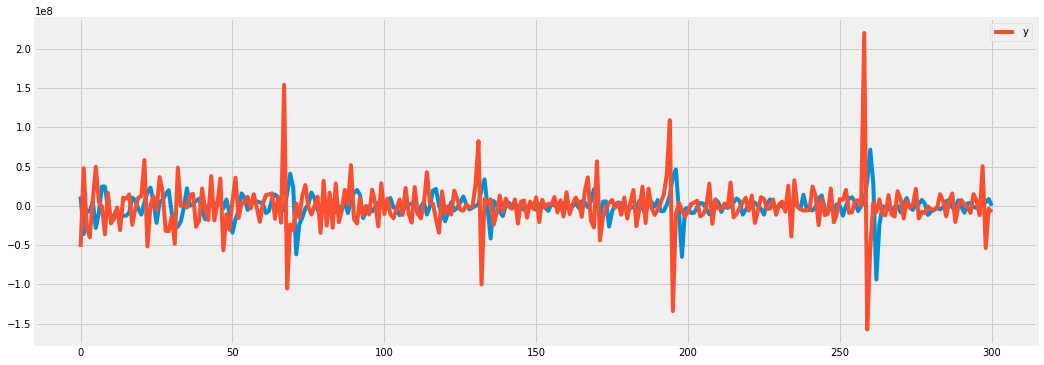

In [80]:
# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(microsoft["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
plt.show()

In [81]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 61937593.98493614.


Taking the slight lag into account, this is a fine model.

### Predictions on microsoft stock using ARIMA

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 3016
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -2269.599
Method:                       css-mle   S.D. of innovations              0.513
Date:                Wed, 05 Jul 2023   AIC                           4551.198
Time:                        18:54:19   BIC                           4587.268
Sample:                             2   HQIC                          4564.169
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.604e-05   1.14e-05      2.288      0.022    3.74e-06    4.83e-05
ar.L1.D2.y    -0.7088        nan        nan        nan         nan         nan
ar.L2.D2.y     0.0240        nan        nan        n

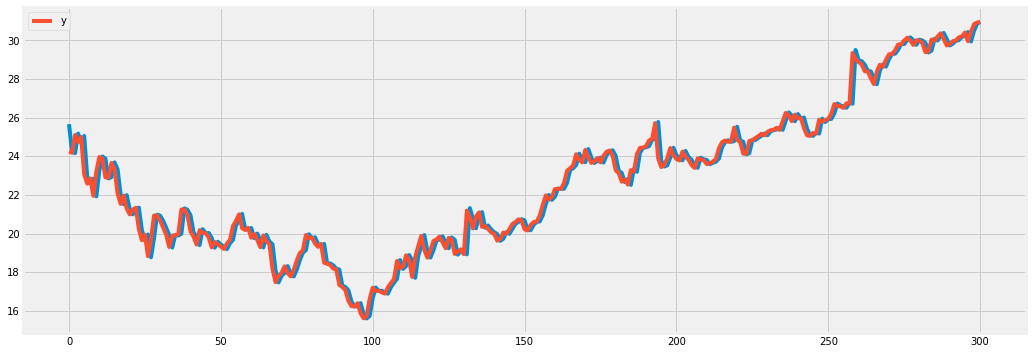

In [82]:

# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(microsoft["High"].iloc[1:].values, order=(2,2,2))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
plt.show()

In [83]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 29505859.567936685.


## Difference between ARIMA and ARIMAX 

[Source](https://varshasaini.in/questions/what-is-the-difference-between-arima-and-arimax/#:~:text=The%20only%20difference%20between%20ARIMA,to%20include%20the%20external%20feature.)

ARIMA (Autoregressive Integrated Moving Average) and ARIMAX (Autoregressive Integrated Moving Average with eXogenous variables) are both time series models that are used for forecasting and analyzing the behavior of a time series. The main difference between the two lies in the inclusion of exogenous variables.

1. `ARIMA Model`:
    ARIMA is a popular and widely used time series model. It is designed to capture the autocorrelation and trend in a time series. The ARIMA model consists of three components: autoregressive (AR), differencing (I), and moving average (MA).

    - Autoregressive (AR): The AR component models the dependence of the current observation on its past values. It uses a linear combination of the lagged values of the endogenous variable.
    - Differencing (I): The differencing component is used to make the time series stationary by removing any trend or seasonality present in the data.
    - Moving Average (MA): The MA component models the dependency of the current observation on past errors (residuals) of the time series.

    The ARIMA model does not include any exogenous variables. It assumes that the behavior of the time series can be explained solely by its own past values.

2. `ARIMAX Model`:
    ARIMAX is an extension of the ARIMA model that allows for the inclusion of exogenous variables, also known as exogenous regressors. These variables are external to the time series being analyzed and are believed to have an impact on the behavior of the endogenous variable.

    In addition to the AR, I, and MA components, the ARIMAX model includes an extra component for the exogenous variables. The exogenous variables are included as additional predictors in the model alongside the autoregressive, differencing, and moving average terms. The coefficients associated with the exogenous variables provide information about their influence on the endogenous variable.

    By incorporating exogenous variables, the ARIMAX model can account for external factors that may affect the time series, leading to improved forecasting accuracy and better understanding of the relationship between the endogenous and exogenous variables.

    In summary, the main difference between ARIMA and ARIMAX models is that ARIMA models only consider the past values of the endogenous variable, while ARIMAX models include exogenous variables as additional predictors to capture the impact of external factors on the time series.
    
    
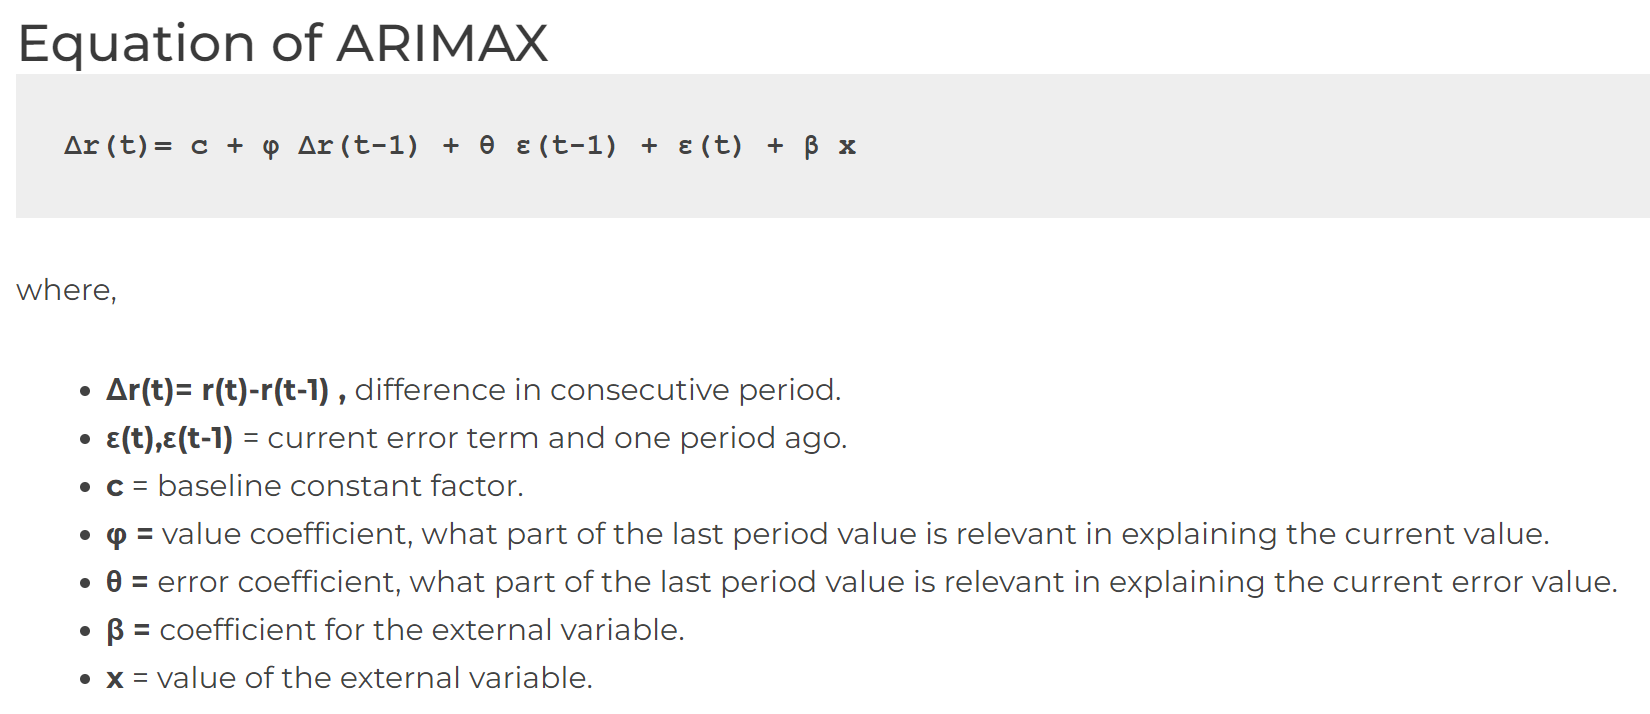

## Adding eXogenous regressor terms to the ARIMA model

In Vector Autoregressive Moving Average with eXogenous regressors (VARMAX) model, the term "eXogenous regressors" refers to additional independent variables that are included in the model alongside the endogenous variables. These exogenous regressors are external to the system being studied and are not influenced by the endogenous variables or the time series itself.

In a VARMAX model, the endogenous variables are modeled as a function of their own past values and the past values of other endogenous variables in the system, similar to a Vector Autoregressive Moving Average (VARMA) model. However, the VARMAX model extends this framework by allowing the inclusion of exogenous regressors, which can capture the influence of external factors on the endogenous variables.

The exogenous regressors are often chosen based on their theoretical relevance to the system under study or their empirical correlation with the endogenous variables. These regressors can be time-varying and can include various types of variables, such as economic indicators, policy variables, or other relevant external factors.

Including exogenous regressors in a VARMAX model can enhance the model's explanatory power, improve the accuracy of forecasts, and capture the impact of external factors on the endogenous variables. The coefficients associated with the exogenous regressors provide information on the magnitude and direction of their influence on the endogenous variables.

It's important to note that the inclusion of exogenous regressors in a VARMAX model assumes that there is a linear relationship between the exogenous variables and the endogenous variables. If non-linear relationships are suspected, alternative modeling techniques may be more appropriate, such as nonlinear VAR models or machine learning algorithms.

## <a id='4.5'>4.5 VAR models</a>
Vector autoregression (VAR) is a stochastic process model used to capture the linear interdependencies among multiple time series. VAR models generalize the univariate autoregressive model (AR model) by allowing for more than one evolving variable. All variables in a VAR enter the model in the same way: each variable has an equation explaining its evolution based on its own lagged values, the lagged values of the other model variables, and an error term. VAR modeling does not require as much knowledge about the forces influencing a variable as do structural models with simultaneous equations: The only prior knowledge required is a list of variables which can be hypothesized to affect each other intertemporally.


                           Statespace Model Results                           
Dep. Variable:     ['Close', 'Close']   No. Observations:                 3018
Model:                     VARMA(2,1)   Log Likelihood              -12185.169
                          + intercept   AIC                          24404.337
Date:                Wed, 05 Jul 2023   BIC                          24506.547
Time:                        18:54:44   HQIC                         24441.091
Sample:                    01-04-2006                                         
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):                77.92, 70.40   Jarque-Bera (JB):   55731.67, 15359.82
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.35, 1.82   Skew:                       1.24, 0.29
Prob(H) (two-sided):            0.00,

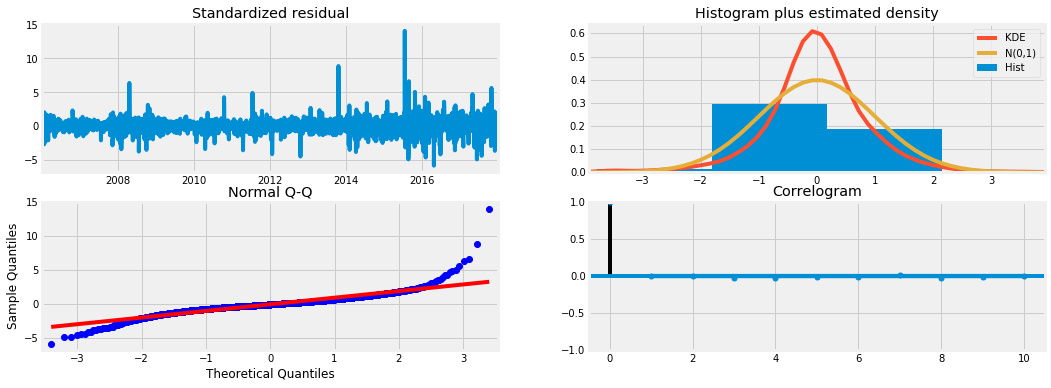

In [84]:
# Predicting closing price of Google and microsoft
train_sample = pd.concat([google["Close"].diff().iloc[1:],microsoft["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

## <a id='4.6'>4.6 State Space methods</a>

A general state space model is of the form

y<sub>t</sub>=Z<sub>t</sub>α<sub>t</sub>+d<sub>t</sub>+ε<sub>t</sub>

α<sub>t</sub>=T<sub>t</sub>α<sub>t</sub>−1+c<sub>t</sub>+R<sub>t</sub>η<sub>t</sub>

where y<sub>t</sub> refers to the observation vector at time t, α<sub>t</sub> refers to the (unobserved) state vector at time t, and where the irregular components are defined as

ε<sub>t</sub>∼N(0,H<sub>t</sub>)

η<sub>t</sub>∼N(0,Q<sub>t</sub>)

The remaining variables (Z<sub>t</sub>,d<sub>t</sub>,H<sub>t</sub>,T<sub>t</sub>,c<sub>t</sub>,R<sub>t</sub>,Q<sub>t</sub>) in the equations are matrices describing the process. Their variable names and dimensions are as follows

Z : design (k_endog×k_states×nobs)

d : obs_intercept (k_endog×nobs)

H : obs_cov (k_endog×k_endog×nobs)

T : transition (k_states×k_states×nobs)

c : state_intercept (k_states×nobs)

R : selection (k_states×k_posdef×nobs)

Q : state_cov (k_posdef×k_posdef×nobs)

In the case that one of the matrices is time-invariant (so that, for example, Z<sub>t</sub>=Z<sub>t</sub>+1 ∀ <sub>t</sub>), its last dimension may be of size 1 rather than size nobs.

This generic form encapsulates many of the most popular linear time series models (see below) and is very flexible, allowing estimation with missing observations, forecasting, impulse response functions, and much more.

Source: [statsmodels](https://www.statsmodels.org/dev/statespace.html)

## <a id='4.6.1'>4.6.1 SARIMA models</a>
SARIMA models are useful for modeling seasonal time series, in which the mean and other statistics for a given season are not stationary across the years. The SARIMA model defined constitutes a straightforward extension of the nonseasonal autoregressive-moving average (ARMA) and autoregressive integrated moving average (ARIMA) models presented

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3018
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -10109.293
Date:                Wed, 05 Jul 2023   AIC                          20238.586
Time:                        18:55:17   BIC                          20298.710
Sample:                             0   HQIC                         20260.206
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2183      0.158      1.380      0.168      -0.092       0.528
ar.L1         -0.5292      0.238     -2.228      0.026      -0.995      -0.064
ar.L2          0.5143      0.208      2.467      0.0

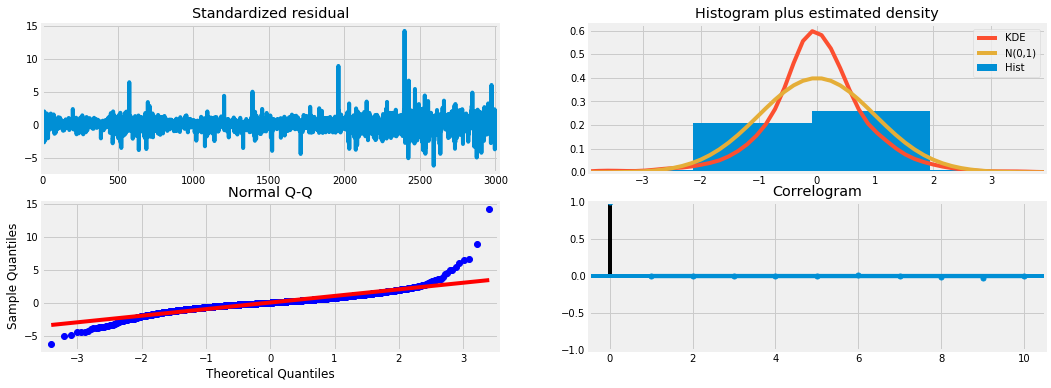

In [85]:
# Predicting closing price of Google'
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

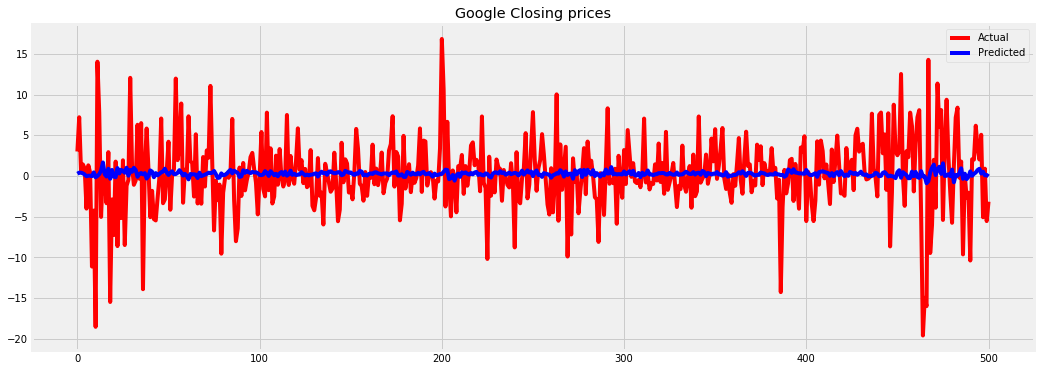

In [86]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

## <a id='4.6.2'>4.6.2 Unobserved components</a>
A UCM decomposes the response series into components such as trend, seasons, cycles, and the regression effects due to predictor series. The following model shows a possible scenario:
<img src="http://support.sas.com/documentation/cdl/en/etsug/66840/HTML/default/images/etsug_ucm0134.png">
Source: [http://support.sas.com/documentation/cdl/en/etsug/66840/HTML/default/viewer.htm#etsug_ucm_details01.htm](http://support.sas.com/documentation/cdl/en/etsug/66840/HTML/default/viewer.htm#etsug_ucm_details01.htm)

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 3018
Model:                    local level   Log Likelihood              -10116.511
Date:                Wed, 05 Jul 2023   AIC                          20237.023
Time:                        18:55:20   BIC                          20249.047
Sample:                             0   HQIC                         20241.347
                               - 3018                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    47.7219      0.384    124.248      0.000      46.969      48.475
sigma2.level      5.033e-05      0.000      0.458      0.647      -0.000       0.000
Ljung-Box (Q):              

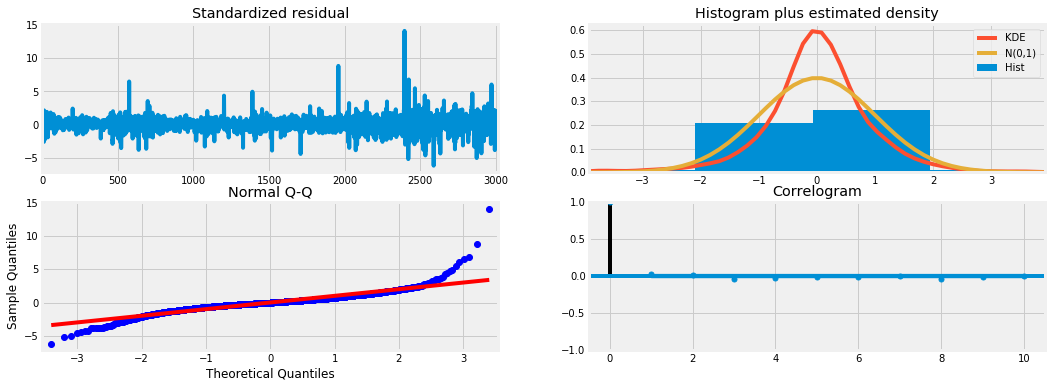

In [87]:
# Predicting closing price of Google'
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

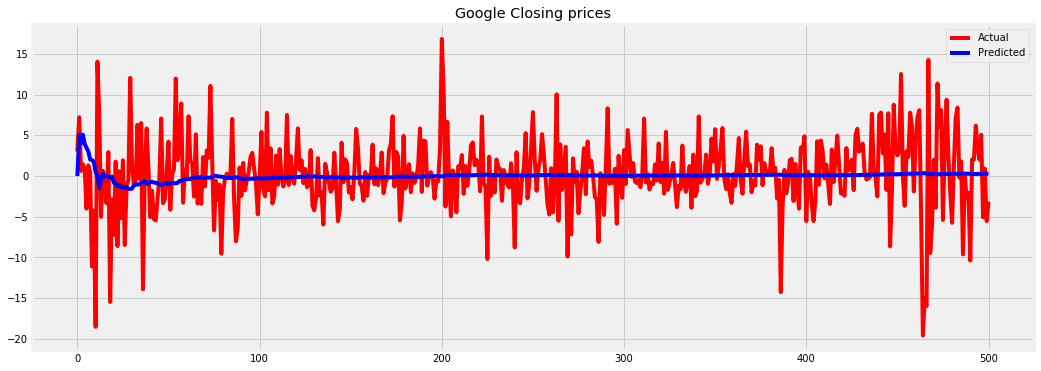

In [88]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

## <a id='4.6.3'>4.6.3 Dynamic Factor models</a>
Dynamic-factor models are flexible models for multivariate time series in which the observed endogenous variables are linear functions of exogenous covariates and unobserved factors, which have a vector autoregressive structure. The unobserved factors may also be a function of exogenous covariates. The disturbances in the equations for the dependent variables may be autocorrelated.

                                   Statespace Model Results                                  
Dep. Variable:                    ['Close', 'Close']   No. Observations:                 3018
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood              -12198.578
Date:                               Wed, 05 Jul 2023   AIC                          24409.156
Time:                                       18:55:31   BIC                          24445.230
Sample:                                   01-04-2006   HQIC                         24422.128
                                        - 12-29-2017                                         
Covariance Type:                                 opg                                         
Ljung-Box (Q):                77.79, 75.22   Jarque-Bera (JB):   55726.97, 15211.11
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.39, 1.81   Skew:                       1.23, 0

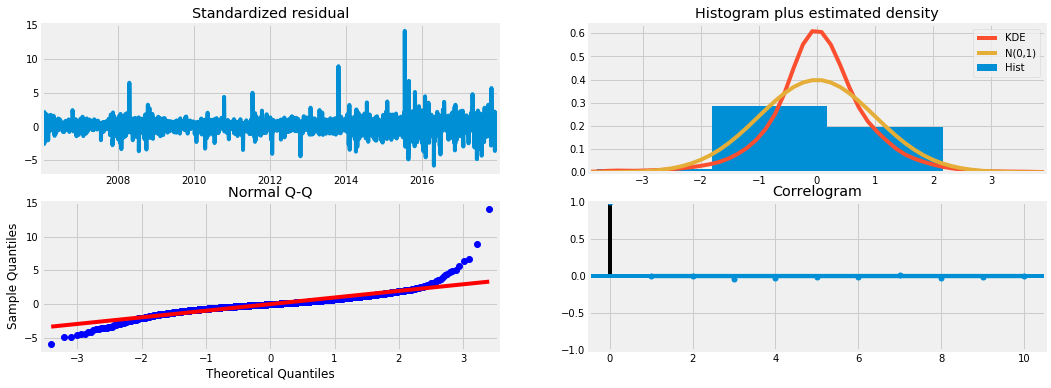

In [89]:
# Predicting closing price of Google and microsoft
train_sample = pd.concat([google["Close"].diff().iloc[1:],microsoft["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))